In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, Bounds
import scipy.special
from scipy.stats import binom
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

import functools

In [3]:
def eta_partial(kappa):
    '''
    Generate Bernoulli(1/2) on marked kappa star
    '''
    multiplicity = np.fromfunction(lambda _, k: scipy.special.comb(kappa, k), (2, kappa+1))
    eta = multiplicity / (2 ** (kappa+1))
    return eta

# def eta(l, k):
#     '''
#     Generate joint Bernoilli(1/2) on marked l-star and k-star
#     '''
#     eta_a_flattened = eta_partial(l).flatten()
#     eta_v_flattened = eta_partial(k).flatten()
#     eta_full = np.outer(eta_a_flattened, eta_v_flattened)
#     return eta_full.reshape(2, l+1, 2, k+1)

def hamiltonian_partial(beta, B, l):
    '''
    Hamiltonian matrix for marked l star
    '''
    return np.fromfunction(lambda x, j: (2 * x - 1) * (beta / 2 * (2 * j - l) + B), shape=(2, l+1))

def get_marginal(name, p):
    '''
    Get the marginal distribution in a tree
    '''
    assert name in {'a', 'v'}
    return np.sum(p, axis=(2, 3) if name=='a' else (0, 1))

# def hamiltonian(beta, B, l, k):
#     hamiltonian_a_reshaped = hamiltonian_partial(beta, B, l)[:, :, np.newaxis, np.newaxis]
#     hamiltonian_v_reshaped = hamiltonian_partial(beta, B, k)[np.newaxis, np.newaxis, :, :]
#     hamiltonian_a_expanded = np.repeat(np.repeat(hamiltonian_a_reshaped, 2, axis=2), k+1, axis=3)
#     hamiltonian_v_expanded = np.repeat(np.repeat(hamiltonian_v_reshaped, 2, axis=0), l+1, axis=1)
#     assert hamiltonian_a_expanded.shape == hamiltonian_v_expanded.shape == (2, l+1, 2, k+1)
#     alpha = k / l
#     return alpha * hamiltonian_a_expanded + hamiltonian_v_expanded

def edge_distribution_partial(p, l):
    '''
    Calculate edge distribution \pi_p
    '''
    counts = np.vstack([
        l - np.arange(l+1),
        np.arange(l+1)
    ])
    return p @ counts.T / l

def edge_distribution_partial_linear(l):
    '''
    Linear form for edge distribution
    '''
    def get_counts(x0, xv, x, j):
        return np.where(x0 == x, l - j + xv * (2 * j - l), 0)
    return np.fromfunction(get_counts, (2, 2, 2, l+1)) / l

def admissibility_linear(l, k):
    '''
    Linear constraint for admissibility given a flattened \mu^a and \mu^v
    '''
    linear_a = edge_distribution_partial_linear(l).reshape(2, 2, 2*(l+1))
    linear_v = edge_distribution_partial_linear(k).reshape(2, 2, 2*(k+1))
    return np.block([
        [linear_a[0, 0], -linear_v[0, 0]],
        [linear_a[0, 1], -linear_v[1, 0]],
        [linear_a[1, 0], -linear_v[0, 1]],
        [linear_a[1, 1], -linear_v[1, 1]],
    ])
    
def edge_distribution_partial_test(p, l):
    '''
    Test that edge_distribution_partial_linear produces the same edge distribution
    '''
    pi_mu = edge_distribution_partial(p, l)
    counts = edge_distribution_partial_linear(l)
    pi_mu2 = np.sum(counts * p, axis=(2, 3))
    
    assert np.all(np.abs(pi_mu - pi_mu2) < 1e-10)

# def edge_distribution(name, p, l, k):
#     return edge_distribution_partial(get_marginal(name, p), l if name=='a' else k)

# def edge_distribution_linear(name, l, k):
#     def get_counts_a(x0, xv, xoa, j, xov, i):
#         return np.where(x0 == xoa, l - j + xv * (2 * j - l), 0)
#     def get_counts_v(x0, xv, xoa, j, xov, i):
#         return np.where(x0 == xov, k - i + xv * (2 * i - k), 0)
#     assert name in {'a', 'v'}
#     if name == 'a':
#         return np.fromfunction(get_counts_a, (2, 2, 2, l+1, 2, k+1)) / l
#     elif name == 'v':
#         return np.fromfunction(get_counts_v, (2, 2, 2, l+1, 2, k+1)) / k
    
# def admissibility_linear(l, k):
#     a_linear = edge_distribution_linear('a', l, k)
#     v_linear = edge_distribution_linear('v', l, k)
#     return np.stack([
#         a_linear[0, 0] - v_linear[0, 0], 
#         a_linear[1, 0] - v_linear[0, 1], 
#         a_linear[0, 1] - v_linear[1, 0], 
#         a_linear[1, 1] - v_linear[1, 1], 
#     ], axis=0)

# def edge_distribution_2(name, p, l, k):
#     counts = edge_distribution_linear(name, l, k)
#     return np.sum(counts * p, axis=(2, 3, 4, 5))

# def edge_distribution_test(p, l, k):
#     assert np.all(np.abs(edge_distribution('a', p, l, k) - edge_distribution_2('a', p, l, k)) < 1e-10)
#     assert np.all(np.abs(edge_distribution('v', p, l, k) - edge_distribution_2('v', p, l, k)) < 1e-10)
    
def check_distibution_partial(pi_mu, l):
    pi_mu_1 = np.sum(pi_mu, axis=0)
    leaf_dist = binom.pmf(np.arange(l+1), l, pi_mu_1[1])
    return np.repeat([leaf_dist], 2, axis=0) / 2

def hat_distibution_partial(pi_mu, l):
    pi_mu_0 = np.sum(pi_mu, axis=1)
    
    leaf_dist_neg = binom.pmf(np.arange(l+1), l, pi_mu[0, 1] / (pi_mu_0[0]+1e-15))
    leaf_dist_pos = binom.pmf(np.arange(l+1), l, pi_mu[1, 1] / (pi_mu_0[1]+1e-15))
    return np.vstack([leaf_dist_neg, leaf_dist_pos]) / 2

def relative_entropy(p, q):
    p_divided_by_q = np.divide(p, q, out=np.ones_like(p), where=(p > 0) & (q > 0))
    partial = p * np.log(p_divided_by_q)
    return np.sum(partial)
    
def objective_function_partial(mu, beta, B, l, _hamiltonian=None):
    '''
    Objective function for one of the marked stars mu
    '''
    if _hamiltonian is None:
        _hamiltonian = hamiltonian_partial(beta, B, l)
    _hamiltonian = np.sum(_hamiltonian * mu)
    
    pi_mu = edge_distribution_partial(mu, l)
    ## TEMPORARY TEST ##
    # edge_distribution_partial_test(mu, l)
    
    check_dist = check_distibution_partial(pi_mu, l)
    hat_dist = hat_distibution_partial(pi_mu, l)
    
    return _hamiltonian - (relative_entropy(mu, check_dist) + relative_entropy(mu, hat_dist)) / 2

def objective_function(mu_a, mu_v, beta, B, l, k, hamiltonian_a=None, hamiltonian_v=None):
    '''
    Full objective function for both marked stars a and v
    '''
    if hamiltonian_a is None:
        hamiltonian_a = hamiltonian_partial(beta, B, l)
    if hamiltonian_v is None:
        hamiltonian_v = hamiltonian_partial(beta, B, k)
    alpha = k / l
    mu_a_obj = objective_function_partial(mu_a, beta, B, l, hamiltonian_a)
    mu_v_obj = objective_function_partial(mu_v, beta, B, k, hamiltonian_v)
    return alpha * mu_a_obj + mu_v_obj

def flat_to_2d(mu, l, k):
    return mu[:2*(l+1)].reshape(2, l+1), \
           mu[2*(l+1):].reshape(2, k+1)
           
def visualize(p, ax, vmin=None, vmax=None):
    '''
    Generates a heatmap for the distribution
    '''
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    im = ax.imshow(p, extent=[0, 2 * p.shape[1], 0, 4], cmap='Greys', vmin=vmin, vmax=vmax)
    for i in range(p.shape[0]):
        for j in range(p.shape[1]):
            text = ax.text(2*j+1, 4 - (2*i+1), f'{p[i, j]:.3f}',
                        ha="center", va="center", color="red")
    return im

@functools.cache
def get_multiplicities(kappa):
    # Get the equivalent configuration for each combined vertex-edge state
    def counts(*vertex_marks):
        stacked = np.stack(vertex_marks, axis=0)
        return np.sum(stacked, axis=0)
    ks = np.fromfunction(counts, [2] * kappa, dtype=np.int64)
    
    return ks

def vertex_distribution(p, kappa):
    '''
    Joint distribution for all edge-vertex pairs
    
    Input:
    p: 1-d array representing distribution on leaf configurations
    
    Output:
    kappa-d array representing the joint distribution of all edge-vertex pairs
    '''
    # Match the configurations with the ones from configurations list
    ks = get_multiplicities(kappa)
    k_reshaped = ks.flatten()
    
    # Calculate probabilities for each one
    probabilities = [p[k] / scipy.special.comb(kappa, k) for k in k_reshaped]
    
    return np.array(probabilities).reshape((2,) * kappa)

l, k = 2, 3
print(f'{eta_partial(l)=}')
print(f'{eta_partial(k)=}')
print(f'{hamiltonian_partial(1, 0, l)=}')
print(f'{hamiltonian_partial(1, 0, k)=}')
eta = eta_partial(l)
pi_eta = edge_distribution_partial(eta, l)
print(f'{pi_eta=}')

print(f'{check_distibution_partial(pi_eta, l)=}')
print(f'{hat_distibution_partial(pi_eta, l)=}')

eta_partial(l)=array([[0.125, 0.25 , 0.125],
       [0.125, 0.25 , 0.125]])
eta_partial(k)=array([[0.0625, 0.1875, 0.1875, 0.0625],
       [0.0625, 0.1875, 0.1875, 0.0625]])
hamiltonian_partial(1, 0, l)=array([[ 1., -0., -1.],
       [-1.,  0.,  1.]])
hamiltonian_partial(1, 0, k)=array([[ 1.5,  0.5, -0.5, -1.5],
       [-1.5, -0.5,  0.5,  1.5]])
pi_eta=array([[0.25, 0.25],
       [0.25, 0.25]])
check_distibution_partial(pi_eta, l)=array([[0.125, 0.25 , 0.125],
       [0.125, 0.25 , 0.125]])
hat_distibution_partial(pi_eta, l)=array([[0.125, 0.25 , 0.125],
       [0.125, 0.25 , 0.125]])


In [9]:
def optimize(beta, B, l, k, mu0=None, verbose=False, ftol=1e-9, max_iter=1000, project_mu0=False, constraint_tol=0, num_trials=1):
    
    hamiltonian_a = hamiltonian_partial(beta, B, l)
    hamiltonian_v = hamiltonian_partial(beta, B, k)
    
    bounds = Bounds(np.zeros(2*(l+k+2)), np.ones(2*(l+k+2)))
    norm_constraint = LinearConstraint(np.block([
        [np.ones(2*(l+1)), np.zeros(2*(k+1))],
        [np.zeros(2*(l+1)), np.ones(2*(k+1))]
        ]), 1-constraint_tol, 1+constraint_tol)
    admissibility_constraint = LinearConstraint(admissibility_linear(l, k), lb=-constraint_tol, ub=constraint_tol)

    if verbose:
        print(f'{beta=:.3f}, {B=:.3f}, {l=}, {k=}')
        
    max_objective = -np.inf
    
    
    for trial in range(num_trials):
    
        success = False
        
        while not success:
            mu0 = np.random.uniform(-1, 1, size=2*(l+k+2))
            mu0[:2*(l+1)] = mu0[:2*(l+1)] / np.sum(mu0[:2*(l+1)])
            mu0[2*(l+1):] = mu0[2*(l+1):] / np.sum(mu0[2*(l+1):])
            # Project onto the closest point on the probability simplex
            if project_mu0:
                res = minimize(lambda mu: np.sum((mu - mu0.flatten())** 2) / 2, x0=mu0.flatten(), 
                            method='trust-constr', 
                            constraints=[norm_constraint, admissibility_constraint], 
                            bounds=bounds)
                # mu0 = res.x.reshape(2, -1)
                if not res.success:
                    print(f'Projection unsuccessfull: {res.message}, trying again')
                    print(f'{beta=:.3f}, {B=:.3f}, {l=}, {k=}')
                
            if verbose:
                mu0_a, mu0_v = flat_to_2d(mu0, l, k)
                print(f'{mu0_a=}\n{mu0_v=}')
        
            res = minimize(lambda mu: -objective_function(*flat_to_2d(mu, l, k), beta, B, l, k, hamiltonian_a, hamiltonian_v),
                        x0=mu0.flatten(), method='SLSQP', 
                        constraints=[norm_constraint, admissibility_constraint],
                        bounds=bounds,
                        options={'ftol': ftol, 'disp': verbose, 'maxiter': max_iter})
            
            if not res.success:
                print(f'Main optimization unsuccessfull: {res.message}, trying again')
                print(f'{beta=:.3f}, {B=:.3f}, {l=}, {k=}')
            else:
                success = True
        
        mu_a, mu_v = flat_to_2d(res.x, l, k)
        objective = objective_function(mu_a, mu_v, beta, B, l, k)
    
    if objective > max_objective:
        max_objective = objective
        max_mu_a, max_mu_v = mu_a, mu_v
        
    if verbose:
        print(f'{max_objective=}\n')
        print(f'{max_mu_a=}\n{max_mu_v=}\n\n{np.sum(max_mu_a)=}\n{np.sum(max_mu_v)=}\n\n{edge_distribution_partial(max_mu_a, l)=}\n{edge_distribution_partial(max_mu_v, k)=}')
    
    return max_mu_a, max_mu_v

beta=0.100, B=-1.000, l=3, k=3
mu0_a=array([[-1.09557833,  1.52932438,  1.42598742,  1.4461389 ],
       [-1.40640154, -0.52085937,  1.11807208, -1.49668354]])
mu0_v=array([[ 0.45275981,  1.00987254, -0.81309115,  0.37788754],
       [-0.77932135,  0.59919339, -0.61652014,  0.76921937]])
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0645191831780987
            Iterations: 70
            Function evaluations: 1245
            Gradient evaluations: 70
max_objective=1.0645191831780987

max_mu_a=array([[7.33692565e-01, 1.75574112e-01, 1.40057029e-02, 3.72409056e-04],
       [5.44942089e-02, 1.94542116e-02, 2.31495883e-03, 9.18310651e-05]])
max_mu_v=array([[7.33690431e-01, 1.75577423e-01, 1.40054860e-02, 3.72538087e-04],
       [5.44932164e-02, 1.94540098e-02, 2.31507652e-03, 9.18198698e-05]])

np.sum(max_mu_a)=1.0000000000000029
np.sum(max_mu_v)=1.0000000000000018

edge_distribution_partial(max_mu_a, l)=array([[0.85541054, 0.06823425],
      

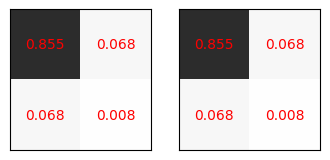

In [13]:
l, k = 3, 3
mu_a, mu_v = optimize(beta=.1, B=-1, l=l, k=k, ftol=1e-10, max_iter=10000, verbose=True, constraint_tol=1e-15)
pi_mu_a = edge_distribution_partial(mu_a, l)
pi_mu_v = edge_distribution_partial(mu_v, k)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))
visualize(pi_mu_a, ax1, vmin=0, vmax=1)
visualize(pi_mu_v, ax2, vmin=0, vmax=1)

In [80]:
x0 = 0
mu0 = np.sum(mu_a, axis=1)
ver_dist = np.sum(vertex_distribution(mu_a[x0] / mu0[x0], l), axis=tuple(i for i in range(2, l)))
print(ver_dist)
ver_dist_x1 = np.sum(ver_dist, axis=1)
ver_dist_x2 = np.sum(ver_dist, axis=0)
print(np.outer(ver_dist_x1, ver_dist_x2))

[[0.70221605 0.13576493]
 [0.13576493 0.02625409]]
[[0.70221212 0.13576886]
 [0.13576886 0.02625016]]


In [ ]:
def vertex_mutual_info(mu, l):
    ver_dist = np.sum(vertex_distribution(mu, l), axis=tuple(i for i in range(2, l)))
    ver_dist_x1 = np.sum(ver_dist, axis=1)
    ver_dist_x2 = np.sum(ver_dist, axis=0)
    return relative_entropy(ver_dist, np.outer(ver_dist_x1, ver_dist_x2))

def func(args):
    beta, B = args
    mu_a, mu_v = optimize(beta, B, 3, 3, ftol=1e-10, constraint_tol=1e-15, num_trials=5)

    mu0a = np.sum(mu_a, axis=1)
    mu0v = np.sum(mu_v, axis=1)
    return (vertex_mutual_info(mu_a[0] / (mu0a[0]+1e-15), l),
            vertex_mutual_info(mu_a[1] / (mu0a[1]+1e-15), l),
            vertex_mutual_info(mu_v[0] / (mu0v[0]+1e-15), k),
            vertex_mutual_info(mu_v[1] / (mu0v[1]+1e-15), k))

l, k = 3, 3
betas = np.linspace(-1, 1, 31)
Bs = np.linspace(-1, 1, 31)
betam, Bm = np.meshgrid(betas, Bs)

mutual_info_a_0 = []
mutual_info_v_0 = []
mutual_info_a_1 = []
mutual_info_v_1 = []
for beta, B in tqdm(zip(betam.flatten(), Bm.flatten()), total=len(betam.flatten())):
    mu_a, mu_v = optimize(beta, B, l, k, ftol=1e-10, constraint_tol=1e-15, num_trials=1)
    
    mu0a = np.sum(mu_a, axis=1)
    mu0v = np.sum(mu_v, axis=1)
    mutual_info_a_0.append(vertex_mutual_info(mu_a[0] / (mu0a[0]+1e-15), l))
    mutual_info_a_1.append(vertex_mutual_info(mu_a[1] / (mu0a[1]+1e-15), l))
    mutual_info_v_0.append(vertex_mutual_info(mu_v[0] / (mu0v[0]+1e-15), k))
    mutual_info_v_1.append(vertex_mutual_info(mu_v[1] / (mu0v[1]+1e-15), k))
    
mutual_info_a_0 = np.array(mutual_info_a_0)
mutual_info_v_0 = np.array(mutual_info_v_0)
mutual_info_a_1 = np.array(mutual_info_a_1)
mutual_info_v_1 = np.array(mutual_info_v_1)

In [64]:
l, k = 6, 6
with open(f"../data/ising_bptt/{l=}_{k=}.npz", "rb") as f:
    npzfile = np.load(f)
    betam = npzfile['betam']
    Bm = npzfile['Bm']
    mutual_info_a_0 = npzfile['mia0']
    mutual_info_a_1 = npzfile['mia1']
    mutual_info_v_0 = npzfile['miv0']
    mutual_info_v_1 = npzfile['miv1']

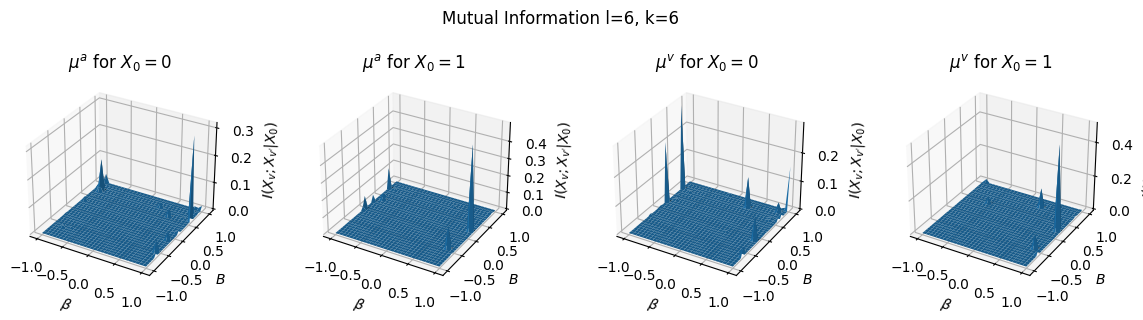

In [65]:
fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(141, projection='3d')
ax2 = fig.add_subplot(142, projection='3d')
ax3 = fig.add_subplot(143, projection='3d')
ax4 = fig.add_subplot(144, projection='3d')
fig.tight_layout()

ax1.plot_surface(betam, Bm, mutual_info_a_0.reshape(31, 31))
ax1.set_xlabel('$\\beta$')
ax1.set_ylabel('$B$')
ax1.set_zlabel('$I(X_v; X_{v\'} | X_0)$')
ax1.set_title('$\mu^a$ for $X_0=0$')

ax2.plot_surface(betam, Bm, mutual_info_a_1.reshape(31, 31))
ax2.set_xlabel('$\\beta$')
ax2.set_ylabel('$B$')
ax2.set_zlabel('$I(X_v; X_{v\'} | X_0)$')
ax2.set_title('$\mu^a$ for $X_0=1$')

ax3.plot_surface(betam, Bm, mutual_info_v_0.reshape(31, 31))
ax3.set_xlabel('$\\beta$')
ax3.set_ylabel('$B$')
ax3.set_zlabel('$I(X_v; X_{v\'} | X_0)$')
ax3.set_title('$\mu^v$ for $X_0=0$')

ax4.plot_surface(betam, Bm, mutual_info_v_1.reshape(31, 31))
ax4.set_xlabel('$\\beta$')
ax4.set_ylabel('$B$')
ax4.set_zlabel('$I(X_v; X_{v\'} | X_0)$')
ax4.set_title('$\mu^v$ for $X_0=1$')

fig.suptitle(f'Mutual Information {l=}, {k=}')

fig.tight_layout()

plt.savefig(f'../img/Ising_bptt/CI_l{l}_k{k}.png')